In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import regex as re
#sentiment analyser imports
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


#auto_arima 
#!pip install pmdarima
from pmdarima import auto_arima

#accuracy check imports
from sklearn.metrics import mean_absolute_error,mean_squared_error
print('done')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
done


In [2]:
news_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/india-news-headlines.csv',
                     )
news_data_copy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/india-news-headlines.csv',
                     )
news_data.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [3]:
news_data.shape

(2577491, 3)

In [4]:
news_data.isnull().sum()

publish_date         0
headline_category    0
headline_text        1
dtype: int64

In [5]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2577491 entries, 0 to 2577490
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 59.0+ MB


In [6]:
news_data['headline_category'].value_counts()

india                               252117
unknown                             209458
city.mumbai                         105194
city.delhi                           96015
business.india-business              91810
                                     ...  
entertainment.events.nashik              2
auto.miscellaneous                       1
elections.assembly-elections.goa         1
cit                                      1
auto.launches                            1
Name: headline_category, Length: 842, dtype: int64

In [7]:
news_data['headline_text']=news_data['headline_text'].astype('str')
news_data['headline_text']=news_data['headline_text'].str.lower()
news_data.dtypes

publish_date          int64
headline_category    object
headline_text        object
dtype: object

In [8]:
#remove unwanted columns
def col_remover(df,col):
  df.drop(col,axis=1,inplace=True)
col_remover(news_data,'headline_category')
#col_remover(news_data,'scores')

In [9]:
news_data.head(100)

,publish_date,headline_text
0,20010102,status quo will not be disturbed at ayodhya; s...
1,20010102,fissures in hurriyat over pak visit
2,20010102,america's unwanted heading for india?
3,20010102,for bigwigs; it is destination goa
4,20010102,extra buses to clear tourist traffic
...,...,...
95,20010103,no report yet on fire in udyog bhavan
96,20010103,he is the king of 'five star' industry
97,20010103,petrol pump sealed for selling adulterated fuel
98,20010103,milk price up by rs 1 per litre


In [10]:
#preprocess date column
news_data['publish_date']=news_data['publish_date'].astype('str')
news_data['publish_date']=news_data['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

In [11]:
news_data.head(10)

,publish_date,headline_text
0,2001-01-02,status quo will not be disturbed at ayodhya; s...
1,2001-01-02,fissures in hurriyat over pak visit
2,2001-01-02,america's unwanted heading for india?
3,2001-01-02,for bigwigs; it is destination goa
4,2001-01-02,extra buses to clear tourist traffic
5,2001-01-02,dilute the power of transfers; says riberio
6,2001-01-02,focus shifts to teaching of hindi
7,2001-01-02,it will become compulsory in schools
8,2001-01-02,move to stop freedom fighters' pension flayed
9,2001-01-02,gilani claims he applied for passport 2 years ago


In [12]:
#groupby date 
news_data_mod=news_data.groupby(['publish_date'])['headline_text'].apply(lambda x:','.join(x)).reset_index()
news_data_mod.head(10)

,publish_date,headline_text
0,2001-01-02,status quo will not be disturbed at ayodhya; s...
1,2001-01-03,"powerless north india gropes in the dark,think..."
2,2001-01-04,the string that pulled stephen hawking to indi...
3,2001-01-05,light combat craft takes india into club class...
4,2001-01-06,light combat craft takes india into club class...
5,2001-01-07,"muslim body rules out talks on ayodhya,bajrang..."
6,2001-01-08,"sangh parivar; babri panel up the ante,frontru..."
7,2001-01-09,financier bharat shah held for alleged links w...
8,2001-01-10,"fend for yourselves; pande tells doctors,burea..."
9,2001-01-23,"sonia takes on the hindutva brigade,congress h..."


In [13]:
#apply vader analyzer on entire news dataset
sid=SentimentIntensityAnalyzer()
#news_data['compound'] = news_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
news_data_mod['scores']=news_data_mod['headline_text'].apply(lambda x:sid.polarity_scores(x))

In [14]:
#create separate columns for scores
news_data_mod['compound']=news_data_mod['scores'].apply(lambda x:x['compound'])
news_data_mod['negative']=news_data_mod['scores'].apply(lambda x:x['neg'])
news_data_mod['positive']=news_data_mod['scores'].apply(lambda x:x['pos'])
news_data_mod['neutral']=news_data_mod['scores'].apply(lambda x:x['neu'])
news_data_mod.head()

,publish_date,headline_text,scores,compound,negative,positive,neutral
0,2001-01-02,status quo will not be disturbed at ayodhya; s...,"{'neg': 0.108, 'neu': 0.82, 'pos': 0.072, 'com...",-0.9426,0.108,0.072,0.820
1,2001-01-03,"powerless north india gropes in the dark,think...","{'neg': 0.084, 'neu': 0.817, 'pos': 0.098, 'co...",0.6322,0.084,0.098,0.817
2,2001-01-04,the string that pulled stephen hawking to indi...,"{'neg': 0.083, 'neu': 0.844, 'pos': 0.073, 'co...",-0.5468,0.083,0.073,0.844
3,2001-01-05,light combat craft takes india into club class...,"{'neg': 0.101, 'neu': 0.746, 'pos': 0.153, 'co...",0.9878,0.101,0.153,0.746
4,2001-01-06,light combat craft takes india into club class...,"{'neg': 0.118, 'neu': 0.709, 'pos': 0.172, 'co...",0.4404,0.118,0.172,0.709


In [15]:
#remove unwanted columns
col_remover(news_data_mod,'headline_text')
col_remover(news_data_mod,'scores')
news_data_mod.head()

,publish_date,compound,negative,positive,neutral
0,2001-01-02,-0.9426,0.108,0.072,0.820
1,2001-01-03,0.6322,0.084,0.098,0.817
2,2001-01-04,-0.5468,0.083,0.073,0.844
3,2001-01-05,0.9878,0.101,0.153,0.746
4,2001-01-06,0.4404,0.118,0.172,0.709


In [16]:
#set date column as the index
news_data_mod.set_index('publish_date',drop=True,inplace=True)

In [17]:
news_data_mod.head()

,compound,negative,positive,neutral
publish_date,,,,
2001-01-02,-0.9426,0.108,0.072,0.820
2001-01-03,0.6322,0.084,0.098,0.817
2001-01-04,-0.5468,0.083,0.073,0.844
2001-01-05,0.9878,0.101,0.153,0.746
2001-01-06,0.4404,0.118,0.172,0.709


#**Preprocessing the Business category news**

In [18]:
#separate business news and then drop category column as it is not needed now

business_news=news_data_copy[news_data_copy['headline_category']=='business.india-business']
business_news.drop('headline_category',axis=1,inplace=True)
business_news.head()

,publish_date,headline_text
275,20010104,Car dealers caught in Bihar sales tax ruling
4564,20010522,Re-negotiation best: Deshmukh; lenders' SOS to...
4632,20010522,Samsung says hello to cellular unit in India
4639,20010522,Govt lifts port-linked curbs on imports
4652,20010522,RIL plans to mop up to Rs 1;000cr


In [19]:
#preprocessing on headline_text column

business_news['headline_text']=business_news['headline_text'].astype('str')
business_news['headline_text']=business_news['headline_text'].str.lower()
business_news.head()

,publish_date,headline_text
275,20010104,car dealers caught in bihar sales tax ruling
4564,20010522,re-negotiation best: deshmukh; lenders' sos to...
4632,20010522,samsung says hello to cellular unit in india
4639,20010522,govt lifts port-linked curbs on imports
4652,20010522,ril plans to mop up to rs 1;000cr


In [20]:
#preprocessig date column
business_news['publish_date']=business_news['publish_date'].astype('str')
business_news['publish_date']=business_news['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])

In [21]:
news_data_mod1=business_news.groupby(['publish_date'])['headline_text'].apply(lambda x:','.join(x)).reset_index()
news_data_mod1.head(10)

,publish_date,headline_text
0,2001-01-04,car dealers caught in bihar sales tax ruling
1,2001-05-22,re-negotiation best: deshmukh; lenders' sos to...
2,2001-05-28,"auto body drives in new classification norms,a..."
3,2001-05-29,"ashok leyland to cut jobs; divisions,'fixing o..."
4,2001-05-30,"beware; the snoopware is watching you!,ia dive..."
5,2001-06-20,centre unveils bailout package for madhavpura ...
6,2001-06-22,"six-point strategy to speed up fdi flows,i-t h..."
7,2001-06-23,strategic partner may get 5 directors on a-i b...
8,2001-06-24,"subsidies on lpg; kerosene to stay: naik,prasa..."
9,2001-06-25,hdfc to buy 8% stake in positra sez for rs 150...


In [22]:
#vader sentiment analyzer
sid=SentimentIntensityAnalyzer()
news_data_mod1['vader_scores']=news_data_mod1['headline_text'].apply(lambda x:sid.polarity_scores(x))

In [23]:
news_data_mod1.head()

,publish_date,headline_text,vader_scores
0,2001-01-04,car dealers caught in bihar sales tax ruling,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,2001-05-22,re-negotiation best: deshmukh; lenders' sos to...,"{'neg': 0.045, 'neu': 0.864, 'pos': 0.091, 'co..."
2,2001-05-28,"auto body drives in new classification norms,a...","{'neg': 0.05, 'neu': 0.886, 'pos': 0.064, 'com..."
3,2001-05-29,"ashok leyland to cut jobs; divisions,'fixing o...","{'neg': 0.17, 'neu': 0.797, 'pos': 0.032, 'com..."
4,2001-05-30,"beware; the snoopware is watching you!,ia dive...","{'neg': 0.074, 'neu': 0.891, 'pos': 0.035, 'co..."


In [24]:
#extract all scores from dict generated from vader sentiment analyzer in above code
news_data_mod1['compound']=news_data_mod1['vader_scores'].apply(lambda x:x['compound'])
news_data_mod1['positive']=news_data_mod1['vader_scores'].apply(lambda x:x['pos'])
news_data_mod1['negative']=news_data_mod1['vader_scores'].apply(lambda x:x['neg'])
news_data_mod1['neutral']=news_data_mod1['vader_scores'].apply(lambda x:x['neu'])

In [25]:
news_data_mod1.head()

,publish_date,headline_text,vader_scores,compound,positive,negative,neutral
0,2001-01-04,car dealers caught in bihar sales tax ruling,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000
1,2001-05-22,re-negotiation best: deshmukh; lenders' sos to...,"{'neg': 0.045, 'neu': 0.864, 'pos': 0.091, 'co...",0.4767,0.091,0.045,0.864
2,2001-05-28,"auto body drives in new classification norms,a...","{'neg': 0.05, 'neu': 0.886, 'pos': 0.064, 'com...",0.1680,0.064,0.050,0.886
3,2001-05-29,"ashok leyland to cut jobs; divisions,'fixing o...","{'neg': 0.17, 'neu': 0.797, 'pos': 0.032, 'com...",-0.8020,0.032,0.170,0.797
4,2001-05-30,"beware; the snoopware is watching you!,ia dive...","{'neg': 0.074, 'neu': 0.891, 'pos': 0.035, 'co...",-0.3382,0.035,0.074,0.891


In [26]:
#remove unwanted columns
col_remover(news_data_mod1,'headline_text')
col_remover(news_data_mod1,'vader_scores')
news_data_mod.head()

,compound,negative,positive,neutral
publish_date,,,,
2001-01-02,-0.9426,0.108,0.072,0.820
2001-01-03,0.6322,0.084,0.098,0.817
2001-01-04,-0.5468,0.083,0.073,0.844
2001-01-05,0.9878,0.101,0.153,0.746
2001-01-06,0.4404,0.118,0.172,0.709


#**Analysis of Nifty50 Dataset**

In [27]:
nifty_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nifty50.csv',index_col='Date')
nifty_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0


In [28]:
nifty_data.isnull().sum()

Open         35
High         35
Low          35
Close        35
Adj Close    35
Volume       35
dtype: int64

In [29]:
#drop missing value rows
nifty_data.dropna(axis='rows',inplace=True)

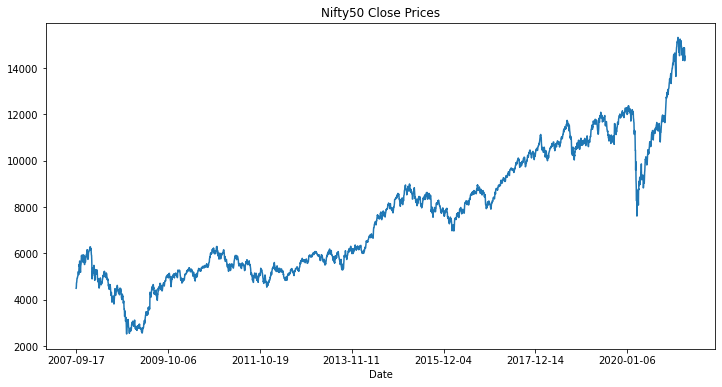

In [30]:
#plot feature to be predicted later
nifty_data['Close'].plot(figsize=(12,6),title='Nifty50 Close Prices')

In [31]:
nifty_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [32]:
#create new columns with rolling mean and stnd deviation of the data features
features=['Open', 'High', 'Low']
window1=3
window2=5
for feature in features:
    nifty_data[feature+'rolling_mean_3']=nifty_data[feature].rolling(window=window1).mean()
    nifty_data[feature+'rolling_mean_5']=nifty_data[feature].rolling(window=window2).mean()
for feature in features:
    nifty_data[feature+'rolling_stnd_3']=nifty_data[feature].rolling(window=window1).std()
    nifty_data[feature+'rolling_stnd_5']=nifty_data[feature].rolling(window=window2).std()
nifty_data.head()

,Open,High,Low,Close,Adj Close,Volume,Openrolling_mean_3,Openrolling_mean_5,Highrolling_mean_3,Highrolling_mean_5,Lowrolling_mean_3,Lowrolling_mean_5,Openrolling_stnd_3,Openrolling_stnd_5,Highrolling_stnd_3,Highrolling_stnd_5,Lowrolling_stnd_3,Lowrolling_stnd_5
Date,,,,,,,,,,,,,,,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902,4494.649902,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195,4546.200195,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098,4732.350098,0.0,4520.933431,NaN,4613.283203,NaN,4504.883301,NaN,28.157197,NaN,108.882622,NaN,39.294093,NaN
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805,4747.549805,0.0,4593.066732,NaN,4683.883301,NaN,4584.316569,NaN,125.956719,NaN,114.908199,NaN,123.379293,NaN
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0,4679.350098,4610.120117,4785.183431,4691.279981,4668.366699,4593.9,112.169647,123.901624,62.038836,135.863305,102.484357,125.096564


In [33]:
nifty_data.isna().sum()

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Openrolling_mean_3    2
Openrolling_mean_5    4
Highrolling_mean_3    2
Highrolling_mean_5    4
Lowrolling_mean_3     2
Lowrolling_mean_5     4
Openrolling_stnd_3    2
Openrolling_stnd_5    4
Highrolling_stnd_3    2
Highrolling_stnd_5    4
Lowrolling_stnd_3     2
Lowrolling_stnd_5     4
dtype: int64

In [34]:
nifty_data.dropna(inplace=True)
nifty_data.isna().sum()

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Openrolling_mean_3    0
Openrolling_mean_5    0
Highrolling_mean_3    0
Highrolling_mean_5    0
Lowrolling_mean_3     0
Lowrolling_mean_5     0
Openrolling_stnd_3    0
Openrolling_stnd_5    0
Highrolling_stnd_3    0
Highrolling_stnd_5    0
Lowrolling_stnd_3     0
Lowrolling_stnd_5     0
dtype: int64

In [35]:
#decide features to include in prediction later
ind_features=['Openrolling_mean_3', 'Openrolling_mean_5', 'Highrolling_mean_3',
       'Highrolling_mean_5', 'Lowrolling_mean_3', 'Lowrolling_mean_5',
       #'Volumerolling_mean_3', 'Volumerolling_mean_5', 
       'Openrolling_stnd_3','Openrolling_stnd_5', 'Highrolling_stnd_3', 'Highrolling_stnd_5',
       'Lowrolling_stnd_3', 'Lowrolling_stnd_5'] 
       #'Volumerolling_stnd_3','Volumerolling_stnd_5']

#**Merging Two DataSets**

###Merging nifty50 ds & news ds 

In [36]:
#nifty50 data in nifty_data_mod & news data in news_data_mod
#data is merged fro 2007 and news data from 2001 to 2007 is not considered
merged_data = pd.concat([nifty_data,news_data_mod],axis=1)
merged_data.head()
#merged_data.shape

,Open,High,Low,Close,Adj Close,Volume,Openrolling_mean_3,Openrolling_mean_5,Highrolling_mean_3,Highrolling_mean_5,Lowrolling_mean_3,Lowrolling_mean_5,Openrolling_stnd_3,Openrolling_stnd_5,Highrolling_stnd_3,Highrolling_stnd_5,Lowrolling_stnd_3,Lowrolling_stnd_5,compound,negative,positive,neutral
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805,4837.549805,0.0,4679.350098,4610.120117,4785.183431,4691.279981,4668.366699,4593.900000,112.169647,123.901624,62.038836,135.863305,102.484357,125.096564,-0.9989,0.140,0.057,0.803
2007-09-24,4837.149902,4941.149902,4837.149902,4932.200195,4932.200195,0.0,4774.983398,4673.860059,4852.566732,4769.700000,4764.000000,4664.759961,54.593122,145.113488,90.190736,146.024320,63.659710,145.197594,-0.9968,0.119,0.083,0.798
2007-09-25,4939.100098,4953.899902,4878.149902,4938.850098,4938.850098,0.0,4843.066732,4762.860059,4916.916666,4850.120019,4816.333333,4744.079980,93.215896,143.757898,53.396937,99.252984,74.440759,127.318836,-0.3788,0.099,0.100,0.802
2007-09-26,4937.600098,4980.850098,4930.350098,4940.500000,4940.500000,0.0,4904.616699,4840.330078,4958.633301,4898.490039,4881.883301,4820.100000,58.432774,97.453011,20.268946,90.068058,46.712127,90.928025,-0.9922,0.128,0.097,0.775
2007-09-27,4942.700195,5016.399902,4942.700195,5000.549805,5000.549805,0.0,4939.800130,4881.900098,4983.716634,4949.600000,4917.066732,4864.410058,2.621122,84.707791,31.348449,59.887107,34.263989,84.401425,-0.9670,0.126,0.122,0.752


In [37]:
#arima model gets error that the data contains infiniite values, so lets do some debugging
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.dropna(inplace=True)
#np.any(np.isnan(train_data)),np.all(np.isfinite(train_data))

In [38]:
#splitting train and test data
#merged_data.shape----->(6865, 26)

train_size=int(len(merged_data)*0.65)
test_size=len(merged_data)-train_size

train_data=merged_data[:train_size]
test_data=merged_data[train_size:]

In [39]:
merged_data.isna().sum()

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Openrolling_mean_3    0
Openrolling_mean_5    0
Highrolling_mean_3    0
Highrolling_mean_5    0
Lowrolling_mean_3     0
Lowrolling_mean_5     0
Openrolling_stnd_3    0
Openrolling_stnd_5    0
Highrolling_stnd_3    0
Highrolling_stnd_5    0
Lowrolling_stnd_3     0
Lowrolling_stnd_5     0
compound              0
negative              0
positive              0
neutral               0
dtype: int64

In [40]:
#apply auto_arima model on merged data
arima_model=auto_arima(y=train_data['Close'],
                       exogenous=train_data[ind_features],
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15840.139, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15793.687, Time=3.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15778.656, Time=6.93 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15838.197, Time=3.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.89 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15624.889, Time=7.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15596.565, Time=7.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15596.018, Time=8.98 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=8.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=9.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=15577.983, Time=11.00 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=9.87 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=11.26 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1

In [41]:
arima_model.fit(train_data['Close'],train_data[ind_features])

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 5), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [42]:
forecast=arima_model.predict(n_periods=len(test_data),exogenous=test_data[ind_features])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [43]:
test_data['Forecast_ARIMA']=forecast

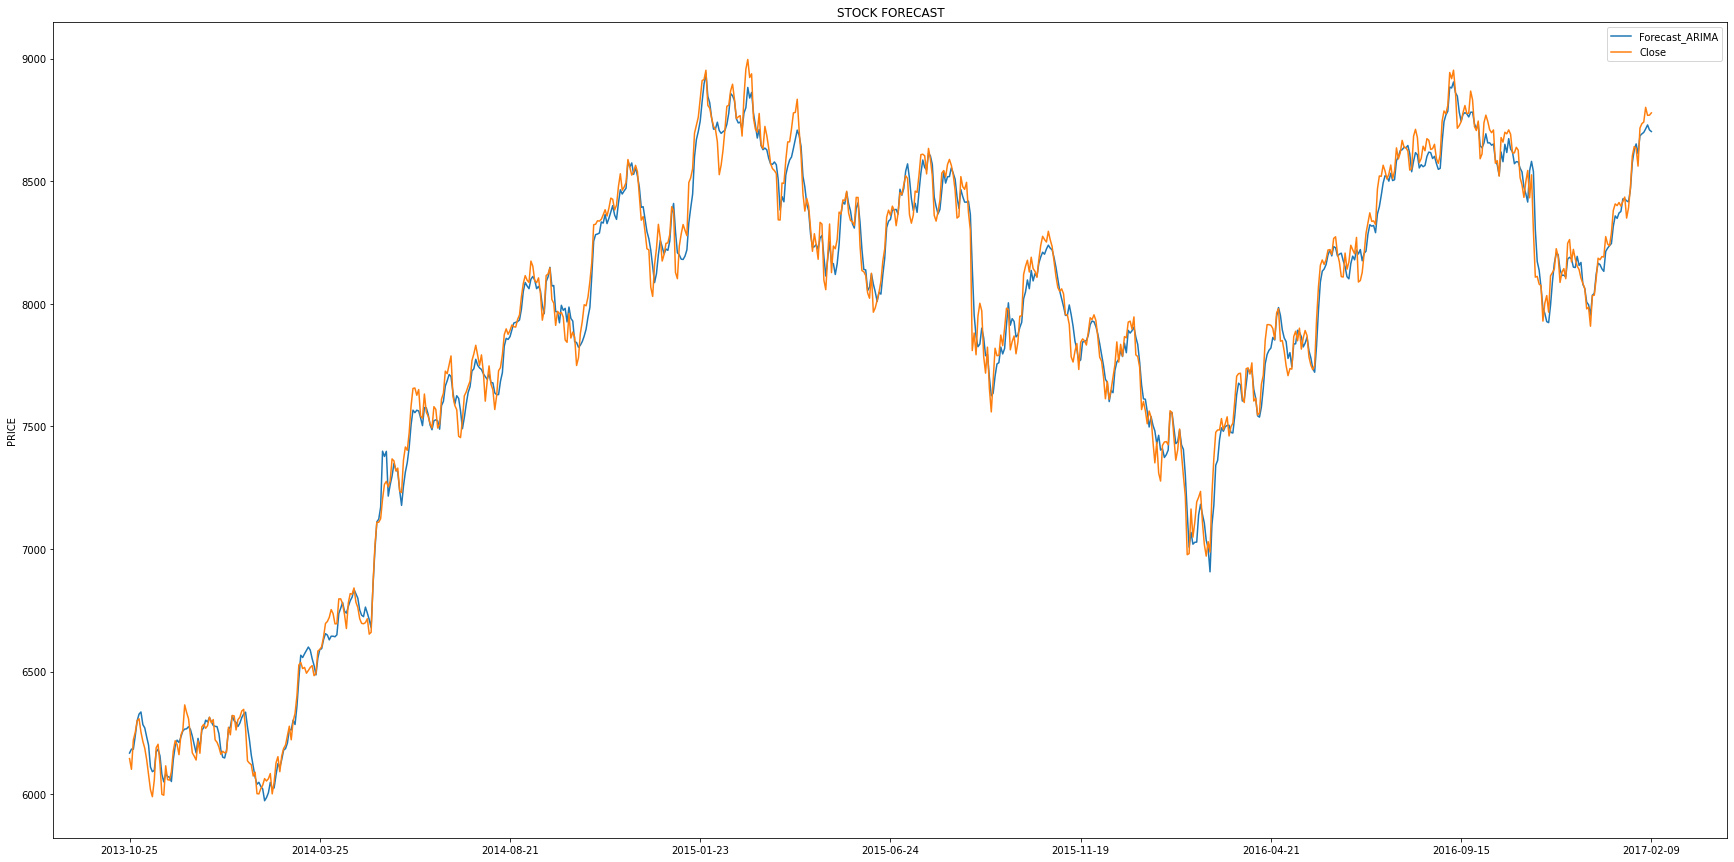

In [44]:
test_data[['Forecast_ARIMA','Close']].plot(figsize=(30,15),title='STOCK FORECAST',ylabel='PRICE')


In [45]:
MAE=mean_absolute_error(test_data['Close'],test_data['Forecast_ARIMA'])
RMSE=np.sqrt(mean_squared_error(test_data['Close'],test_data['Forecast_ARIMA']))

print('MAE:{}'.format(MAE))
print('RMSE:{}'.format(RMSE))

MAE:47.318006042808655
RMSE:61.14768276905942
